In [60]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from os import listdir
from tqdm import tqdm

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

intput_path = "../input/"
output_path = "../output/"

In [55]:
npys = [f for f in sorted(listdir(output_path)) if f.endswith("_oof.npy") and f[0]!="!"]
npys

['cat_0.91617_oof.npy',
 'lgb_0.91145_oof.npy',
 'nn_0.9163_oof.npy',
 'xgb_0.91221_oof.npy']

In [89]:
path = output_path+"predictions/train/"
csvs = [f for f in sorted(listdir(path)) if f.endswith(".csv")][-6:]
csvs

['9197_lightgbm_unique_10x_upsample_0104035943.csv',
 '9199_xgboost_unique_10x_upsample_0104062006.csv',
 '9211_catboost_unique_with_10x_upsample_3103172847.csv',
 '9212_catboost_unique_10x_upsample_5_balancer_0204172825.csv',
 '9215_catboost_unique_10x_upsample_3_balancer_0204145755.csv',
 '9223_catboost_unique_10_fold_20x_upsample_0104001611.csv']

In [90]:
scaler = StandardScaler()

dt = pd.DataFrame()

df = pd.read_csv(intput_path+'train.csv.zip')
df = df[["target"]]

cols = []
for file in tqdm(npys):
    train = np.load(output_path+file).reshape(-1, 1)
    col = file[:-4]
    cols.append(col)
    df[col] = scaler.fit_transform(train)
    
    test = np.load(output_path+file.replace("_oof.npy","_test.npy")).reshape(-1, 1)
    dt[col] = [x[0] for x in scaler.transform(test)]
    
for file in tqdm(csvs):
    train = pd.read_csv(path+file)["target"].values.reshape(-1, 1)
    col = file[:-4]
    cols.append(col)
    df[col] = scaler.fit_transform(train)
    
    test = pd.read_csv((path+file).replace("/train/","/test/"))["target"].values.reshape(-1, 1)
    dt[col] = [x[0] for x in scaler.transform(test)]
    
df["avg"] = df[cols].mean(axis=1)
dt["avg"] = dt[cols].mean(axis=1)

dt.head()

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


,cat_0.91617_oof,lgb_0.91145_oof,nn_0.9163_oof,xgb_0.91221_oof,9197_lightgbm_unique_10x_upsample_0104035943,9199_xgboost_unique_10x_upsample_0104062006,9211_catboost_unique_with_10x_upsample_3103172847,9212_catboost_unique_10x_upsample_5_balancer_0204172825,9215_catboost_unique_10x_upsample_3_balancer_0204145755,9223_catboost_unique_10_fold_20x_upsample_0104001611,avg
0,-0.028851,-0.045147,0.329803,-0.058851,-0.019374,0.070145,-0.001326,0.088417,0.122535,-0.029213,0.042814
1,0.630567,0.880821,1.106001,0.659944,0.633215,0.965392,0.968773,1.062013,0.892895,0.926662,0.872628
2,1.006787,0.910918,0.878276,0.883434,0.893022,0.659628,0.702412,0.959692,0.651046,0.662674,0.820789
3,0.844511,0.394093,0.953653,0.427158,0.365700,0.404615,0.396050,0.621631,0.418294,0.391706,0.521741
4,-0.234038,-0.149319,0.088908,-0.114493,-0.092834,-0.140038,-0.194537,0.088031,0.007907,-0.208206,-0.094862


In [91]:
df[cols].corr()

,cat_0.91617_oof,lgb_0.91145_oof,nn_0.9163_oof,xgb_0.91221_oof,9197_lightgbm_unique_10x_upsample_0104035943,9199_xgboost_unique_10x_upsample_0104062006,9211_catboost_unique_with_10x_upsample_3103172847,9212_catboost_unique_10x_upsample_5_balancer_0204172825,9215_catboost_unique_10x_upsample_3_balancer_0204145755,9223_catboost_unique_10_fold_20x_upsample_0104001611
cat_0.91617_oof,1.000000,0.973739,0.811705,0.973639,0.951756,0.954016,0.955159,0.922901,0.939684,0.951474
lgb_0.91145_oof,0.973739,1.000000,0.800824,0.984808,0.932934,0.935317,0.933944,0.900169,0.916886,0.930237
nn_0.9163_oof,0.811705,0.800824,1.000000,0.797771,0.838847,0.844554,0.839587,0.875173,0.861009,0.841766
xgb_0.91221_oof,0.973639,0.984808,0.797771,1.000000,0.933083,0.935253,0.934652,0.899439,0.917013,0.931016
9197_lightgbm_unique_10x_upsample_0104035943,0.951756,0.932934,0.838847,0.933083,1.000000,0.993763,0.990564,0.974594,0.983696,0.985797
9199_xgboost_unique_10x_upsample_0104062006,0.954016,0.935317,0.844554,0.935253,0.993763,1.000000,0.992339,0.977547,0.985802,0.987988
9211_catboost_unique_with_10x_upsample_3103172847,0.955159,0.933944,0.839587,0.934652,0.990564,0.992339,1.000000,0.977718,0.987955,0.994654
9212_catboost_unique_10x_upsample_5_balancer_0204172825,0.922901,0.900169,0.875173,0.899439,0.974594,0.977547,0.977718,1.000000,0.993757,0.975632
9215_catboost_unique_10x_upsample_3_balancer_0204145755,0.939684,0.916886,0.861009,0.917013,0.983696,0.985802,0.987955,0.993757,1.000000,0.985245
9223_catboost_unique_10_fold_20x_upsample_0104001611,0.951474,0.930237,0.841766,0.931016,0.985797,0.987988,0.994654,0.975632,0.985245,1.000000


## AVG

In [93]:
roc_auc_score(df.target, df.avg)
# 0.9223641761399094

0.9223641761399094

## LogReg

In [94]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["clf"] = 0
dt["clf"] = 0

i = -1
for train_index, valid_index in skf.split(df[cols], df.target):
    i+=1
    
    X_train = df.loc[train_index, cols]
    X_valid = df.loc[valid_index, cols]

    y_train = df.loc[train_index, "target"]
    y_valid = df.loc[valid_index, "target"]
    
    clf = LogisticRegression(C=1,
                             solver="newton-cg",
                             penalty="l2", 
                             n_jobs=-1, 
                             max_iter=100).fit(X_train, y_train) 
    
    y_pred = clf.predict_proba(X_valid)[:,1] 
    df.loc[valid_index, "clf"] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
    dt["clf"] += clf.predict_proba(dt[cols])[:,1] / skf.n_splits
    
print("\nROC AUC:", round(roc_auc_score(df.target, df["clf"]), 4))

0 ROC AUC: 0.9219
1 ROC AUC: 0.92
2 ROC AUC: 0.9273
3 ROC AUC: 0.923
4 ROC AUC: 0.9204

ROC AUC: 0.9223
CPU times: user 3.61 s, sys: 12.5 s, total: 16.1 s
Wall time: 10.3 s


In [ ]:
# 0 ROC AUC: 0.9219
# 1 ROC AUC: 0.92
# 2 ROC AUC: 0.9273
# 3 ROC AUC: 0.923
# 4 ROC AUC: 0.9204

# ROC AUC: 0.9223
# CPU times: user 3.61 s, sys: 12.5 s, total: 16.1 s
# Wall time: 10.3 s

## SVM

In [ ]:
# %%time

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# df["svc"] = 0
# dt["svc"] = 0

# i = -1
# for train_index, valid_index in skf.split(df[cols], df.target):
#     i+=1
    
#     X_train = df.loc[train_index, cols]
#     X_valid = df.loc[valid_index, cols]

#     y_train = df.loc[train_index, "target"]
#     y_valid = df.loc[valid_index, "target"]
    
#     svc = SVC(C=10, probability=True).fit(X_train, y_train)  
    
#     y_pred = svc.predict_proba(X_valid)[:,1] 
#     df.loc[valid_index, "svc"] = y_pred
#     print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
#     dt["svc"] += svc.predict_proba(dt[cols].values) / skf.n_splits
    
# print("\nROC AUC:", round(roc_auc_score(df.target, df["svc"]), 4))

## NN

In [95]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["nei"] = 0
dt["nei"] = 0

i = -1
for train_index, valid_index in skf.split(df[cols], df.target):
    i+=1
    
    X_train = df.loc[train_index, cols]
    X_valid = df.loc[valid_index, cols]

    y_train = df.loc[train_index, "target"]
    y_valid = df.loc[valid_index, "target"]
    
    nei = KNeighborsClassifier(n_neighbors=1000, p=1, n_jobs=-1).fit(X_train, y_train) 
    
    y_pred = nei.predict_proba(X_valid)[:,1] 
    df.loc[valid_index, "nei"] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
    dt["nei"] += nei.predict_proba(dt[cols])[:,1] / skf.n_splits
    
print("\nROC AUC:", round(roc_auc_score(df.target, df["nei"]), 4))

0 ROC AUC: 0.9215
1 ROC AUC: 0.9214
2 ROC AUC: 0.9269
3 ROC AUC: 0.9218
4 ROC AUC: 0.9195

ROC AUC: 0.9221
CPU times: user 3h 40min 58s, sys: 1min 38s, total: 3h 42min 37s
Wall time: 9min 45s


In [ ]:
# 0 ROC AUC: 0.9215
# 1 ROC AUC: 0.9214
# 2 ROC AUC: 0.9269
# 3 ROC AUC: 0.9218
# 4 ROC AUC: 0.9195

# ROC AUC: 0.9221
# CPU times: user 3h 40min 58s, sys: 1min 38s, total: 3h 42min 37s
# Wall time: 9min 45s

## LGBM

In [ ]:
%%time

rounds = 1000
early_stop_rounds = 100

params = {'lambda_l1': 0, 
          'lambda_l2': 0,
          'learning_rate': 0.03, 
          'max_depth': 3,
          'boosting_type': 'gbrt', 
          'objective': 'binary', 
          'metric': 'auc',
          'max_bin': 512,
          'n_jobs':-1
         }

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df["lgb"] = 0
dt["lgb"] = 0

i = -1
for train_index, valid_index in skf.split(df[cols], df.target):
    i+=1
    
    X_train = df.loc[train_index, cols]
    X_valid = df.loc[valid_index, cols]

    y_train = df.loc[train_index, "target"]
    y_valid = df.loc[valid_index, "target"]
    
    d_train = lgb.Dataset(X_train, y_train, feature_name=cols)
    d_valid = lgb.Dataset(X_valid, y_valid, feature_name=cols)    
    
    model = lgb.train(params,
                      d_train,
                      num_boost_round=rounds,
                      valid_sets=[d_train, d_valid],
                      valid_names=['train','valid'],
                      early_stopping_rounds=early_stop_rounds,
                      verbose_eval=0) 

    y_pred = model.predict(X_valid)
    df.loc[valid_index, "lgb"] = y_pred
    print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))
    
    dt["lgb"] += model.predict(dt[cols]) / skf.n_splits
    
print("\nROC AUC:", round(roc_auc_score(df.target, df["lgb"]), 4))

0 ROC AUC: 0.9222


In [ ]:
# 0 ROC AUC: 0.9222
# 1 ROC AUC: 0.9219
# 2 ROC AUC: 0.9279
# 3 ROC AUC: 0.9237
# 4 ROC AUC: 0.9207

# ROC AUC: 0.9228
# CPU times: user 7min 39s, sys: 1.71 s, total: 7min 41s
# Wall time: 17.1 s

Text(0.5,1,'Light GBM Feature Importance')

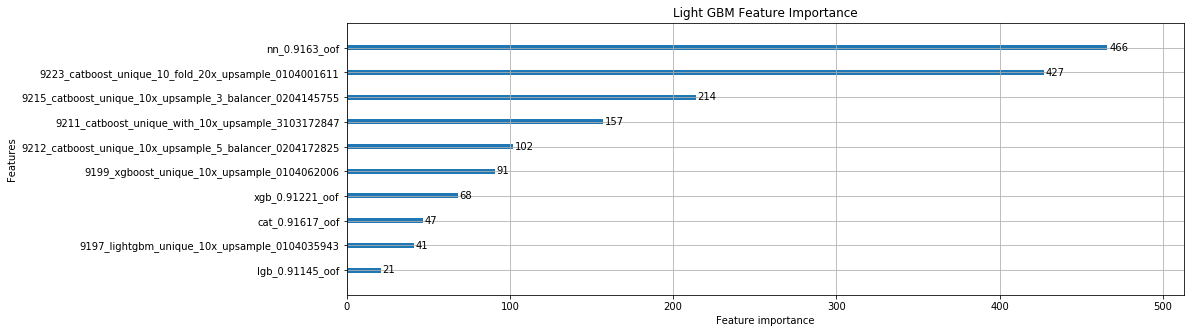

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 5))
lgb.plot_importance(model, max_num_features=len(cols), ax=ax)
plt.title("Light GBM Feature Importance")

In [134]:
w = [1,1,1]

df["blend"] = (w[0]*df["lgb"]+w[1]*df["nei"]+w[2]*df["clf"])/sum(w)
dt["blend"] = (w[0]*dt["lgb"]+w[1]*dt["nei"]+w[2]*dt["clf"])/sum(w)

print("\nROC AUC:", round(roc_auc_score(df.target, df["blend"]), 4))


ROC AUC: 0.9231


In [40]:
sub = pd.read_csv(intput_path+'sample_submission.csv.zip')
sub["target"] = dt["blend"]
sub.head()

,ID_code,target
0,test_0,0.063179
1,test_1,0.224664
2,test_2,0.205822
3,test_3,0.203759
4,test_4,0.040400


In [41]:
sub.to_csv(output_path + "best_blend_10.csv", index=False)

In [42]:
!ls ../output/

 best_auc_nn.pkl	  cat_0.91617_oof.npy	 nn_0.9163_oof.npy
 best_blend.csv		  cat_0.91617_test.npy	 nn_0.9163_test.npy
'!cat_0.91558_oof.npy'	  lgb_0.91145_oof.npy	 xgb_0.91221_oof.npy
'!cat_0.91558_test.npy'   lgb_0.91145_test.npy	 xgb_0.91221_test.npy


In [43]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f ../output/best_blend_10.csv -m "0.9191 lgb,nei,clf"

100%|██████████████████████████████████████| 6.07M/6.07M [00:05<00:00, 1.26MB/s]
Successfully submitted to Santander Customer Transaction Prediction